In [1]:
from astroquery.mast import Observations
from astropy.io import fits 
from astropy.table import Table
import matplotlib.pyplot as plt 
import numpy as np

from astropy.io import ascii

from glob import glob
from drizzlepac import astrodrizzle

import os

%matplotlib notebook 

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol


## Downloading some relevant data

#### Get the table of observations associated with 15238 

In [2]:
obsTable = Observations.query_criteria(proposal_id=['15238'], obs_id=['IDNM0J030'])

#### Get the full list of products associated to the table and restrict the list to IMA files

In [3]:
product_list = Observations.get_product_list(obsTable)
BM = (product_list['productSubGroupDescription']  == 'IMA') 
product_list = product_list[BM]

product_list.show_in_notebook(display_length=5)

idx,obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights
0,2007958812,HST,image,idnm0jodq,DADS IMA file - Intermediate Mult-Accum WFC3/NICMOS,S,mast:HST/product/idnm0jodq_ima.fits,AUXILIARY,--,IMA,--,CALWF3,3.5.0(Oct-09-2018),15238,idnm0jodq_ima.fits,168261120,2007958851,PUBLIC
1,2007958815,HST,image,idnm0jofq,DADS IMA file - Intermediate Mult-Accum WFC3/NICMOS,S,mast:HST/product/idnm0jofq_ima.fits,AUXILIARY,--,IMA,--,CALWF3,3.5.0(Oct-09-2018),15238,idnm0jofq_ima.fits,168261120,2007958851,PUBLIC


#### Pick a single exposure file to work on - to create usable data you will have to follow this work flow on all individual IMA files in your dataset.

In [27]:
myID = product_list['obsID'][0:1]

#### Download the IMA and FLT files for that exposure. The standard pipeline-FLT will be used for comparison with the detrended final product

In [28]:
download = Observations.download_products(myID,mrp_only=False,productSubGroupDescription=['IMA','FLT'])

#### Display the results of the download operation

In [29]:
download

Local Path,Status,Message,URL
str47,str8,object,object
./mastDownload/HST/idnm0jodq/idnm0jodq_ima.fits,COMPLETE,None,None
./mastDownload/HST/idnm0jodq/idnm0jodq_flt.fits,COMPLETE,None,None


#### Read the files that were just downloaded locally 

In [30]:
#have path be everything minus last 8 characters (ima.fits)
localpathtofile = download['Local Path'][0][:-8]
localpathtofile

original_ima = fits.open(localpathtofile+'ima.fits')
original_flt = fits.open(localpathtofile+'flt.fits')
original_ima.info()

Filename: ./mastDownload/HST/idnm0jodq/idnm0jodq_ima.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     260   ()      
  1  SCI           1 ImageHDU        81   (1024, 1024)   float32   
  2  ERR           1 ImageHDU        43   (1024, 1024)   float32   
  3  DQ            1 ImageHDU        35   (1024, 1024)   int16   
  4  SAMP          1 ImageHDU        30   ()      
  5  TIME          1 ImageHDU        30   ()      
  6  SCI           2 ImageHDU        81   (1024, 1024)   float32   
  7  ERR           2 ImageHDU        43   (1024, 1024)   float32   
  8  DQ            2 ImageHDU        35   (1024, 1024)   int16   
  9  SAMP          2 ImageHDU        30   ()      
 10  TIME          2 ImageHDU        30   ()      
 11  SCI           3 ImageHDU        81   (1024, 1024)   float32   
 12  ERR           3 ImageHDU        43   (1024, 1024)   float32   
 13  DQ            3 ImageHDU        35   (1024, 1024)   int16   
 14  SAMP          

#### Plot the individual reads of the IMA file
Note: the individual 'SCI' extensions are stored in reverse order, with 'SCI', 1 corresponding to the last read

NSAMP 16


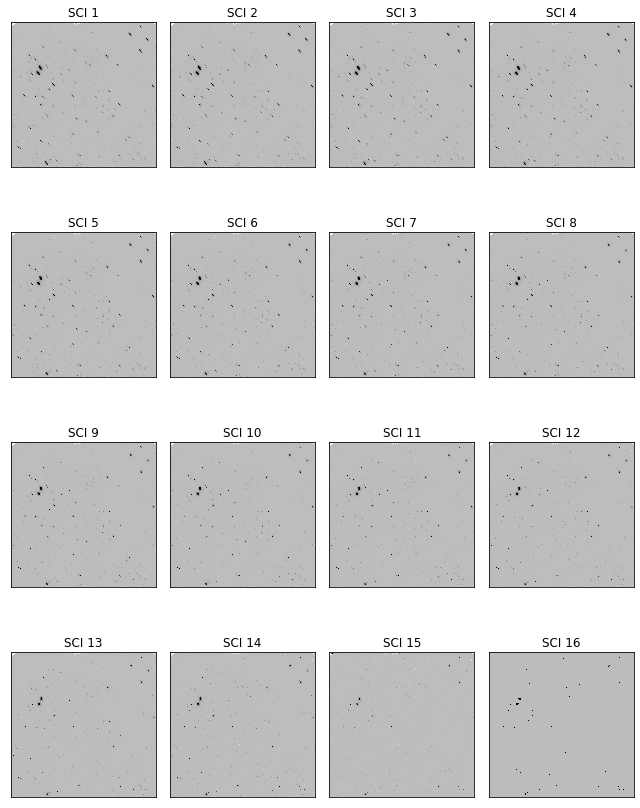

In [31]:
nsamp = original_ima[0].header['NSAMP']
print('NSAMP',nsamp)
fig,axarr = plt.subplots((nsamp+3)//4,4, figsize=(9,3*((nsamp+3)//4)))

for i in range(1,4*((nsamp+3)//4)+1):

    row = (i-1)//4
    col = (i-1)%4
    if (i <= nsamp):
        immed = np.nanmedian(original_ima['SCI',i].data)
        stdev = np.nanstd(original_ima['SCI',i].data)
        axarr[row,col].imshow(original_ima['SCI',i].data,clim=[immed-.3*stdev,immed+.5*stdev],cmap='Greys',origin='lower')
        axarr[row,col].set_title('SCI '+str(i))
        axarr[row,col].set_xticks([]) 
        axarr[row,col].set_yticks([]) 
    else:
        fig.delaxes(axarr[row,col])

fig.tight_layout()

## Run the individual steps of the DASH pipeline
Run the DASH pipeline for a single exposure.  
This procedure showcases the capabilities and customization options of the DASH pipeline.


#### This cell is inserted temporarily to allow for relative imports until the whole wfc3_dash submodule is properly packaged and installed within the wfc3_tools module

In [32]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from reduce_dash import DashData

### 1. Create a DashData object using the path to the IMA file we have downloaded above

In [48]:
myDash = DashData(localpathtofile+'ima.fits', flt_file_name=localpathtofile+'flt.fits')
print(myDash.root)

idnm0jodq


### 2. Create diff files

A diff file contains the counts accumulated between two reads.  
The diff files are written to disk in a directory named ./diff under the current working directory (cwd).  
In creating diff files, the first difference, between the 1-st and 0-th read is ignored becuase of   
its very short expsoure time of 2.9 seconds, resulting in a noisy image.

In order to create a correct error extension, the split_ima() method calls the utils.get_flat() function and the utils.get_IDCtable function.  
The get_flat function reads the name of the flat field used for calibrating the ima images from the ima file header.  
The get_IDCtable reads the name of image distortion correction table, a reference file containing distortion coefficients that are used to correct for distortion in MAST drizzled data products.  
If the flat file is not present locally in a directory named ./iref under the cwd, get_flat() will download   
the flat field file from the CRDS database https://hst-crds.stsci.edu/unchecked_get/references/hst/ 
and place it in ./iref . Similarly for the IDC table.

In [49]:
myDash.split_ima()

Writing idnm0jodq_01_diff.fits
Writing idnm0jodq_02_diff.fits
Writing idnm0jodq_03_diff.fits
Writing idnm0jodq_04_diff.fits
Writing idnm0jodq_05_diff.fits
Writing idnm0jodq_06_diff.fits
Writing idnm0jodq_07_diff.fits
Writing idnm0jodq_08_diff.fits
Writing idnm0jodq_09_diff.fits
Writing idnm0jodq_10_diff.fits
Writing idnm0jodq_11_diff.fits
Writing idnm0jodq_12_diff.fits
Writing idnm0jodq_13_diff.fits
Writing idnm0jodq_14_diff.fits


#### Plot the diff files

Number of diff files 14


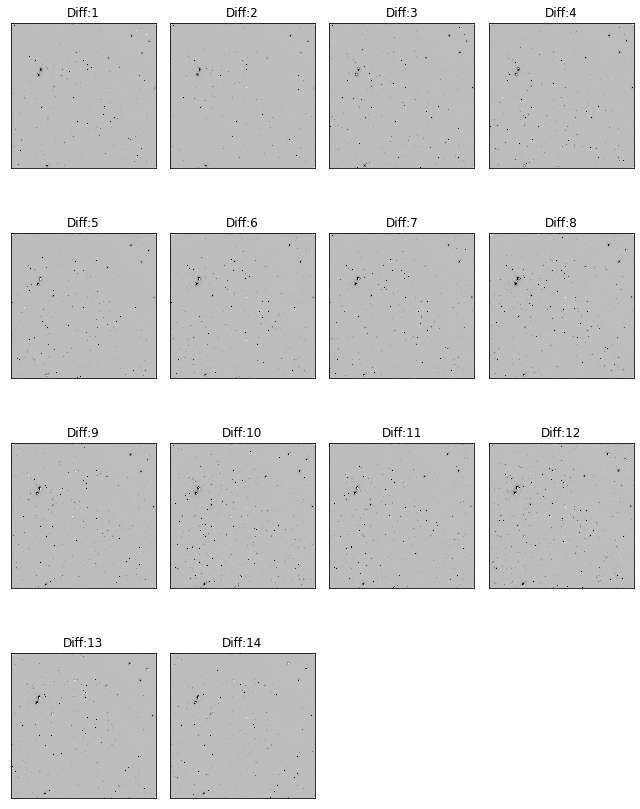

In [50]:
ndiff = len(myDash.diff_files_list)
print('Number of diff files',ndiff)

if ndiff > 4: 
    fig,axarr = plt.subplots((ndiff+3)//4,4, figsize=(9,3*((ndiff+3)//4)))

    for i in range(4*((ndiff+3)//4)):

        row = (i)//4
        col = (i)%4
        if (i < ndiff):
            diff_i = fits.open(myDash.diff_files_list[i]+'_diff.fits')
            immed = np.nanmedian(diff_i['SCI'].data)
            stdev = np.nanstd(diff_i['SCI'].data)
            axarr[row,col].imshow(diff_i['SCI'].data,clim=[immed-.3*stdev,immed+.5*stdev],cmap='Greys',origin='lower')
            axarr[row,col].set_title('Diff:'+str(i+1))
            axarr[row,col].set_xticks([]) 
            axarr[row,col].set_yticks([]) 
        else:
            fig.delaxes(axarr[row,col])
else:
    fig,axarr = plt.subplots(1,ndiff,figsize=(15,15))
    for i in range(ndiff):
        immed = np.nanmedian(diff_i['SCI'].data)
        stdev = np.nanstd(diff_i['SCI'].data)
        diff_i = fits.open(myDash.diff_files_list[i]+'_diff.fits')
        axarr[i].imshow(diff_i['SCI'].data,clim=[immed-.3*stdev,immed+.5*stdev],cmap='Greys',origin='lower')
        axarr[i].set_title('Diff:'+str(i+1))
        axarr[i].set_xticks([]) 
        axarr[i].set_yticks([]) 

fig.tight_layout()

### 3. Create an association file

This file mimics a typical association file for dithered exposures, that is used by astrodrizzle   
to align and stack multiple exposures taken at the same sky position with small dithers.  
We exploit the fact that a WFC3/IR exposure taken under gyro control can be effectively split into   
individual pseudo-exposures (the diff images).  
Astrodrizzle can treat such pseudo-expsoures as individual dithers, and combine them.

In [51]:
myDash.make_pointing_asn()

#### Show the content of the asn file

In [52]:
asn_filename = 'diff/{}_asn.fits'.format(myDash.root)
asn_table = Table(fits.getdata(asn_filename, ext=1))
asn_table.show_in_notebook()

idx,MEMNAME,MEMTYPE,MEMPRSNT
0,diff/idnm0jodq,EXP-DTH,True
1,diff/idnm0jodq,EXP-DTH,True
2,diff/idnm0jodq,EXP-DTH,True
3,diff/idnm0jodq,EXP-DTH,True
4,diff/idnm0jodq,EXP-DTH,True
5,diff/idnm0jodq,EXP-DTH,True
6,diff/idnm0jodq,EXP-DTH,True
7,diff/idnm0jodq,EXP-DTH,True
8,diff/idnm0jodq,EXP-DTH,True
9,diff/idnm0jodq,EXP-DTH,True


### 4. Create Segmentation Map

#### Create segmentation map from original FLT
Make segmentation map from original FLT image to assist with background subtraction and fixing of cosmic ray flags.  
We first use `create_seg_map` to create a segmentation map from the original FLT file using `photutils`.   

In [54]:
myDash.create_seg_map()

#### View segmentation map.

segmentation_maps/idnm0jodq_seg.fits


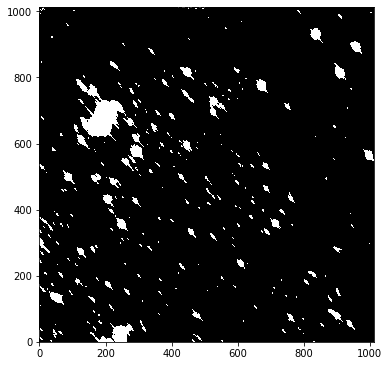

In [59]:
rootname = myDash.root
segmap_name = ('segmentation_maps/'+ rootname + '_seg.fits')
segmap = fits.getdata(segmap_name)
print(segmap_name)
fig = plt.figure(figsize=(6, 8))
plt.imshow(segmap, origin='lower', vmin=0, vmax=1, cmap='Greys_r')

#### Print and read source list.

In [60]:
sourcelist_name = ('segmentation_maps/' + rootname + '_source_list.dat')
sourcelist = ascii.read(sourcelist_name)
print(sourcelist)

 id xcentroid ycentroid sky_centroid ...  cxx   cxy   cyy          gini       
--- --------- --------- ------------ ... ----- ----- ----- -------------------
  1    190.61      9.13         None ...  0.01  0.02  0.04  0.2039628615153731
  2    250.86     16.55         None ...  0.03   0.0  0.02  0.9049254245846183
  3    831.06      0.75         None ...  0.79  1.16  1.42 0.49788514862682487
  4     35.51      3.08         None ...  0.51  0.52  0.62 0.08218134272612847
  5    464.51      4.61         None ...  0.63  0.86  0.66  0.5084918048007754
  6    553.64      3.05         None ...  1.51  0.87  0.86 0.41226811609523234
  7      4.37     14.39         None ...  0.21  0.14  0.04 0.09296774374140447
  8     483.2     12.26         None ...  0.27  0.48  0.29 0.44529223867266376
  9     46.29     17.32         None ...  0.36  0.44  0.22  0.1042606814722472
 10    468.96     22.03         None ...  1.22  1.37  1.24  0.3986572509291627
...       ...       ...          ... ...   ...   ...

#### Create segmentation map and source list from diff files
Make source lists from our difference files created from the IMA so that `TweakReg` can better align these difference files to catalogs, each other, etc.
The function `diff_seg_map` needs a list of difference files that contain the full path name.

In [61]:
diffpath = os.path.dirname(os.path.abspath('diff/{}_*_diff.fits'.format(rootname)))
cat_images=sorted([os.path.basename(x) for x in glob('diff/{}_*_diff.fits'.format(rootname))])

sc_diff_files = [diffpath + '/' + s for s in cat_images]

In [62]:
myDash.diff_seg_map(cat_images=sc_diff_files)

segmentation_maps/idnm0jodq_01_diff_seg.fits


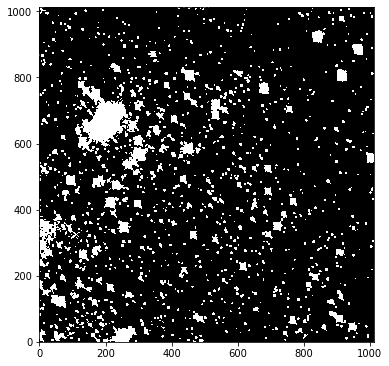

In [66]:
segmap_name = ('segmentation_maps/' + rootname + '_01_diff_seg.fits')
segmap = fits.getdata(segmap_name)
print(segmap_name)
fig = plt.figure(figsize=(6, 8))
plt.imshow(segmap, origin='lower', vmin=0, vmax=1, cmap='Greys_r')

### 5. Subtract Background from diff files
Subtract background from the individual reads taken from the original IMA file using the DRZ and SEG imaged produced in the background subtraction of the original FLT.  
By default, this function will subtract the background and write it to the header. Setting parameter subtract to False will not subtract the background and only write it to the header.  
Set parameter reset_stars_dq to True to reset cosmic rays within objects to 0 (because the centers of the stars are flagged).

In [67]:
myDash.subtract_background_reads()

Background subtraction, diff/idnm0jodq_01_diff.fits:  2.8160829544067383
Background subtraction, diff/idnm0jodq_02_diff.fits:  2.7538065910339355
Background subtraction, diff/idnm0jodq_03_diff.fits:  2.732679843902588
Background subtraction, diff/idnm0jodq_04_diff.fits:  2.7171664237976074
Background subtraction, diff/idnm0jodq_05_diff.fits:  2.6971795558929443
Background subtraction, diff/idnm0jodq_06_diff.fits:  2.713263750076294
Background subtraction, diff/idnm0jodq_07_diff.fits:  2.6931371688842773
Background subtraction, diff/idnm0jodq_08_diff.fits:  2.6907668113708496
Background subtraction, diff/idnm0jodq_09_diff.fits:  2.697809934616089
Background subtraction, diff/idnm0jodq_10_diff.fits:  2.7095773220062256
Background subtraction, diff/idnm0jodq_11_diff.fits:  2.6731414794921875
Background subtraction, diff/idnm0jodq_12_diff.fits:  2.65543532371521
Background subtraction, diff/idnm0jodq_13_diff.fits:  2.6474802494049072
Background subtraction, diff/idnm0jodq_14_diff.fits:  2.

### 6. Fix Cosmic Rays

In [68]:
myDash.fix_cosmic_rays()

Starting 4 L.A.Cosmic iterations
Iteration 1:
936 cosmic pixels this iteration
Iteration 2:
288 cosmic pixels this iteration
Iteration 3:
295 cosmic pixels this iteration
Iteration 4:
293 cosmic pixels this iteration


### 7. Align reads to each other
Align reads to one another by aligning each to the first diff file.  

Uses TweakReg to update the WCS information in the headers of the diff files, then drizzles the images together using Astrodrizzle.  

Refer to documentation to customize parameters for TweakReg and AstroDrizzle. 

(`NOTE: UnboundLocalError: local variable 'sig' referenced before assignment` --> Can be solved by lowering threshold parameter)

Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/idnm0jodq_01_diff.fits:  0.04265093803405762
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/idnm0jodq_02_diff.fits:  0.03333008289337158
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/idnm0jodq_03_diff.fits:  0.02912437915802002
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/idnm0jodq_04_diff.fits:  0.030338287353515625
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/idnm0jodq_05_diff.fits:  0.03071141242980957
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/idnm0jodq_06_diff.fits:  0.029596567153930664
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/idnm0jodq_07_diff.fits:  0.03121042251586914
Keyw

Replacing primary WCS with
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240


AstrometryDB service available...
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
Updating astrometry for idnm0jodq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/idnm0jodq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "idnm0jodq"
Updating idnm0jodq with:
	Headerlet with WCSNAME=IDC_w3m18525i
	Headerlet with WCSNAME=OPUS
	Headerlet with WCSNAME=OPUS-GSC240
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240
Initializing new WCSCORR table for  /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_02_diff.fits
INFO: 
                Inconsistent SIP distortion information is pr

Replacing primary WCS with
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240


AstrometryDB service available...
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
Updating astrometry for idnm0jodq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/idnm0jodq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "idnm0jodq"
Updating idnm0jodq with:
	Headerlet with WCSNAME=IDC_w3m18525i
	Headerlet with WCSNAME=OPUS
	Headerlet with WCSNAME=OPUS-GSC240
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240
Initializing new WCSCORR table for  /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_03_diff.fits
INFO: 
                Inconsistent SIP distortion information is pr

Replacing primary WCS with
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240


AstrometryDB service available...
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
Updating astrometry for idnm0jodq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/idnm0jodq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "idnm0jodq"
Updating idnm0jodq with:
	Headerlet with WCSNAME=IDC_w3m18525i
	Headerlet with WCSNAME=OPUS
	Headerlet with WCSNAME=OPUS-GSC240
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240
Initializing new WCSCORR table for  /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_04_diff.fits
INFO: 
                Inconsistent SIP distortion information is pr

Replacing primary WCS with
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240


AstrometryDB service available...
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
Updating astrometry for idnm0jodq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/idnm0jodq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "idnm0jodq"
Updating idnm0jodq with:
	Headerlet with WCSNAME=IDC_w3m18525i
	Headerlet with WCSNAME=OPUS
	Headerlet with WCSNAME=OPUS-GSC240
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240
Initializing new WCSCORR table for  /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_05_diff.fits
INFO: 
                Inconsistent SIP distortion information is pr

Replacing primary WCS with
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240


AstrometryDB service available...
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
Updating astrometry for idnm0jodq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/idnm0jodq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "idnm0jodq"
Updating idnm0jodq with:
	Headerlet with WCSNAME=IDC_w3m18525i
	Headerlet with WCSNAME=OPUS
	Headerlet with WCSNAME=OPUS-GSC240
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240
Initializing new WCSCORR table for  /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_06_diff.fits
INFO: 
                Inconsistent SIP distortion information is pr

Replacing primary WCS with
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240


AstrometryDB service available...
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
Updating astrometry for idnm0jodq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/idnm0jodq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "idnm0jodq"
Updating idnm0jodq with:
	Headerlet with WCSNAME=IDC_w3m18525i
	Headerlet with WCSNAME=OPUS
	Headerlet with WCSNAME=OPUS-GSC240
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240
Initializing new WCSCORR table for  /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_07_diff.fits
INFO: 
                Inconsistent SIP distortion information is pr

Replacing primary WCS with
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240


AstrometryDB service available...
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
Updating astrometry for idnm0jodq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/idnm0jodq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "idnm0jodq"
Updating idnm0jodq with:
	Headerlet with WCSNAME=IDC_w3m18525i
	Headerlet with WCSNAME=OPUS
	Headerlet with WCSNAME=OPUS-GSC240
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240
Initializing new WCSCORR table for  /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_08_diff.fits
INFO: 
                Inconsistent SIP distortion information is pr

Replacing primary WCS with
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240


AstrometryDB service available...
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
Updating astrometry for idnm0jodq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/idnm0jodq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "idnm0jodq"
Updating idnm0jodq with:
	Headerlet with WCSNAME=IDC_w3m18525i
	Headerlet with WCSNAME=OPUS
	Headerlet with WCSNAME=OPUS-GSC240
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240
Initializing new WCSCORR table for  /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_09_diff.fits
INFO: 
                Inconsistent SIP distortion information is pr

Replacing primary WCS with
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240


AstrometryDB service available...
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
Updating astrometry for idnm0jodq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/idnm0jodq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "idnm0jodq"
Updating idnm0jodq with:
	Headerlet with WCSNAME=IDC_w3m18525i
	Headerlet with WCSNAME=OPUS
	Headerlet with WCSNAME=OPUS-GSC240
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240
Initializing new WCSCORR table for  /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_10_diff.fits
INFO: 
                Inconsistent SIP distortion information is pr

Replacing primary WCS with
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240


AstrometryDB service available...
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
Updating astrometry for idnm0jodq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/idnm0jodq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "idnm0jodq"
Updating idnm0jodq with:
	Headerlet with WCSNAME=IDC_w3m18525i
	Headerlet with WCSNAME=OPUS
	Headerlet with WCSNAME=OPUS-GSC240
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240
Initializing new WCSCORR table for  /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_11_diff.fits
INFO: 
                Inconsistent SIP distortion information is pr

Replacing primary WCS with
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240


AstrometryDB service available...
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
Updating astrometry for idnm0jodq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/idnm0jodq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "idnm0jodq"
Updating idnm0jodq with:
	Headerlet with WCSNAME=IDC_w3m18525i
	Headerlet with WCSNAME=OPUS
	Headerlet with WCSNAME=OPUS-GSC240
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240
Initializing new WCSCORR table for  /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_12_diff.fits
INFO: 
                Inconsistent SIP distortion information is pr

Replacing primary WCS with
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240


AstrometryDB service available...
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
Updating astrometry for idnm0jodq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/idnm0jodq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "idnm0jodq"
Updating idnm0jodq with:
	Headerlet with WCSNAME=IDC_w3m18525i
	Headerlet with WCSNAME=OPUS
	Headerlet with WCSNAME=OPUS-GSC240
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240
Initializing new WCSCORR table for  /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_13_diff.fits
INFO: 
                Inconsistent SIP distortion information is pr

Replacing primary WCS with
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240


AstrometryDB service available...
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
Updating astrometry for idnm0jodq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/idnm0jodq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "idnm0jodq"
Updating idnm0jodq with:
	Headerlet with WCSNAME=IDC_w3m18525i
	Headerlet with WCSNAME=OPUS
	Headerlet with WCSNAME=OPUS-GSC240
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240
Initializing new WCSCORR table for  /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_14_diff.fits
INFO: 
                Inconsistent SIP distortion information is pr

Replacing primary WCS with
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240


Setting up logfile :  tweakreg.log
TweakReg Version 1.4.7(18-April-2018) started at: 16:15:59.830 (10/12/2019) 

Version Information
--------------------
Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]
3.7.4 (default, Aug 13 2019, 15:17:50) 
numpy Version -> 1.17.2 
astropy Version -> 3.2.2 
stwcs Version -> 1.5.3 

Finding shifts for: 
    /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_01_diff.fits
    /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_02_diff.fits
    /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_03_diff.fits
    /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_04_diff.fits
    /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_05_diff.fits
    /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_06_diff.fits
    /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_07_diff.fits
    /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_08_diff.fits
    /user/cmartlin/wfc3_dash/wfc3_dash/


Final solution based on  746  objects.
wrote XY data to:  idnm0jodq_04_diff_catalog_fit.match
Total # points: 746
# of points after clipping: 746
Total # points: 746
# of points after clipping: 746

Performing fit for: /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_05_diff.fits

Matching sources from '/user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_05_diff.fits' with sources from reference image '/user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_01_diff.fits'
Computing initial guess for X and Y shifts...
Found initial X and Y shifts of -5.044, 4.904 with significance of 483.4 and 830 matches
Found 758 matches for /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_05_diff.fits...
Performing "rscale" fit
Computed  rscale  fit for  /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_05_diff.fits : 
XSH: -4.7597  YSH: 5.0921    ROT: 0.001678405931    SCALE: 0.999975
FIT XRMS: 0.2        FIT YRMS: 0.18   
FIT RMSE: 0.27       FIT MAE: 0.2

Performing "rscale" fit
Computed  rscale  fit for  /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_12_diff.fits : 
XSH: -13.1267  YSH: 13.9721    ROT: 0.0003597048674    SCALE: 0.999983
FIT XRMS: 0.21       FIT YRMS: 0.21   
FIT RMSE: 0.3        FIT MAE: 0.24   

RMS_RA: 7.4e-06 (deg)   RMS_DEC: 9.9e-06 (deg)

Final solution based on  714  objects.
wrote XY data to:  idnm0jodq_12_diff_catalog_fit.match
Total # points: 714
# of points after clipping: 714
Total # points: 714
# of points after clipping: 714

Performing fit for: /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_13_diff.fits

Matching sources from '/user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_13_diff.fits' with sources from reference image '/user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_01_diff.fits'
Computing initial guess for X and Y shifts...
Found initial X and Y shifts of -14.81, 16.08 with significance of 454 and 799 matches
Found 739 matches for /user/cmartlin/wfc3_da

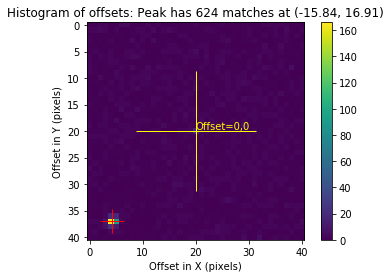

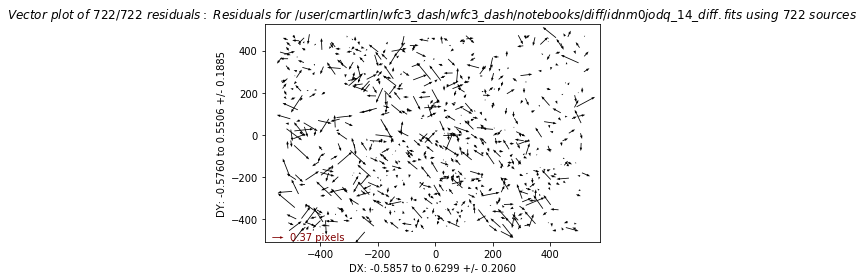

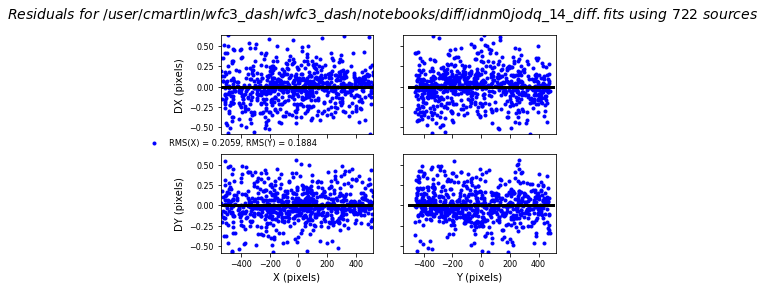

In [69]:
myDash.align(updatehdr=False, updateWCS=False, astrodriz=False)

Print the shifts file to analyze how well the alignment went.
Do not update header until shifts are satisfactory.

In [70]:
shift_file = glob('shifts/shifts_*.txt')
print(open(shift_file[0]).read())

# frame: output
# refimage: shifts/shifts_idnm0jodq_wcs.fits[wcs]
# form: delta
# units: pixels
/user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_01_diff.fits    0.000000  0.000000    0.000000     1.000000   0.000000  0.000000
/user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_02_diff.fits    -0.974970  1.018999    359.999400     0.999984   0.179217  0.173768
/user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_03_diff.fits    -2.311326  2.399806    0.001170     0.999979   0.167075  0.149865
/user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_04_diff.fits    -3.407972  3.623689    359.997819     0.999983   0.201241  0.177244
/user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_05_diff.fits    -4.759732  5.092129    0.001678     0.999975   0.196311  0.183066
/user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_06_diff.fits    -5.807723  6.198633    0.000487     0.999987   0.192433  0.185710
/user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff

Update header and WCS information, then plot final drizzled image.

Listed below are all the inputs available through the function call to `myDash.align()` which runs `TweakReg` and `AstroDrizzle`; there are more inputs available to users when working with `TweakReg` and `Astrodrizzle` that could be an integral part of the workflow for users of DASH. The example in this 

```myDash.align(self, subtract_background = True, 
            align_method = None, 
            ref_catalog = None, 
            create_diff_source_lists = True,
            updatehdr = True, 
            updateWCS = True, 
            wcsname = 'DASH', 
            threshold = 50., 
            cw = 3.5, 
            searchrad = 20., 
            astrodriz = True, 
            cat_file = 'catalogs/diff_catfile.cat',
            drz_output = None, 
            move_files = False)```

Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/idnm0jodq_01_diff.fits:  0.04265093803405762
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/idnm0jodq_02_diff.fits:  0.03333008289337158
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/idnm0jodq_03_diff.fits:  0.02912437915802002
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/idnm0jodq_04_diff.fits:  0.030338287353515625
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/idnm0jodq_05_diff.fits:  0.03071141242980957
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/idnm0jodq_06_diff.fits:  0.029596567153930664
Keyword BG_SUB already set to Yes. Skipping background subtraction.
Background subtraction, diff/idnm0jodq_07_diff.fits:  0.03121042251586914
Keyw

AstrometryDB service available...
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
Updating astrometry for idnm0jodq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/idnm0jodq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "idnm0jodq"
Updating idnm0jodq with:
Replacing primary WCS with
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240


AstrometryDB service available...
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
Updating astrometry for idnm0jodq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/idnm0jodq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "idnm0jodq"
Updating idnm0jodq with:
Replacing primary WCS with
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240


AstrometryDB service available...
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
Updating astrometry for idnm0jodq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/idnm0jodq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "idnm0jodq"
Updating idnm0jodq with:
Replacing primary WCS with
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240


AstrometryDB service available...
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
Updating astrometry for idnm0jodq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/idnm0jodq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "idnm0jodq"
Updating idnm0jodq with:
Replacing primary WCS with
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240


AstrometryDB service available...
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
Updating astrometry for idnm0jodq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/idnm0jodq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "idnm0jodq"
Updating idnm0jodq with:
Replacing primary WCS with
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240


AstrometryDB service available...
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
Updating astrometry for idnm0jodq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/idnm0jodq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "idnm0jodq"
Updating idnm0jodq with:
Replacing primary WCS with
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240


AstrometryDB service available...
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
Updating astrometry for idnm0jodq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/idnm0jodq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "idnm0jodq"
Updating idnm0jodq with:
Replacing primary WCS with
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240


AstrometryDB service available...
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
Updating astrometry for idnm0jodq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/idnm0jodq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "idnm0jodq"
Updating idnm0jodq with:
Replacing primary WCS with
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240


AstrometryDB service available...
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
Updating astrometry for idnm0jodq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/idnm0jodq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "idnm0jodq"
Updating idnm0jodq with:
Replacing primary WCS with
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240


AstrometryDB service available...
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
Updating astrometry for idnm0jodq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/idnm0jodq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "idnm0jodq"
Updating idnm0jodq with:
Replacing primary WCS with
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240


AstrometryDB service available...
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
Updating astrometry for idnm0jodq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/idnm0jodq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "idnm0jodq"
Updating idnm0jodq with:
Replacing primary WCS with
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240


AstrometryDB service available...
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
Updating astrometry for idnm0jodq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/idnm0jodq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "idnm0jodq"
Updating idnm0jodq with:
Replacing primary WCS with
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240


AstrometryDB service available...
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
Updating astrometry for idnm0jodq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/idnm0jodq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "idnm0jodq"
Updating idnm0jodq with:
Replacing primary WCS with
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240


Setting up logfile :  tweakreg.log
TweakReg Version 1.4.7(18-April-2018) started at: 16:17:18.584 (10/12/2019) 

Version Information
--------------------
Python Version [Clang 4.0.1 (tags/RELEASE_401/final)]
3.7.4 (default, Aug 13 2019, 15:17:50) 
numpy Version -> 1.17.2 
astropy Version -> 3.2.2 
stwcs Version -> 1.5.3 

Restoring WCS solutions to original state using updatewcs...

AstrometryDB service available...
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
Updating astrometry for idnm0jodq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/idnm0jodq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS" for ob

Retrieving astrometrically-updated WCS "OPUS" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "OPUS-GSC240" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i-GSC240" for observation "idnm0jodq"
Updating idnm0jodq with:
Replacing primary WCS with
	Headerlet with WCSNAME=IDC_w3m18525i-GSC240
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
- IDCTAB: Distortion model from row 8 for chip 1 : F139M
Updating astrometry for idnm0jodq
Accessing AstrometryDB service :
	https://mast.stsci.edu/portal/astrometryDB/observation/read/idnm0jodq
AstrometryDB service call succeeded
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "idnm0jodq"
Retrieving astrometrically-updated WCS "IDC_w3m18525i" for observation "idnm0jodq"
Retrieving astrometrically-update

     Found 1091 objects.
===  FINAL number of objects in image '/user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_02_diff.fits': 1091

===  Source finding for image '/user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_03_diff.fits':
     Found 1069 objects.
===  FINAL number of objects in image '/user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_03_diff.fits': 1069

===  Source finding for image '/user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_04_diff.fits':
     Found 1129 objects.
===  FINAL number of objects in image '/user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_04_diff.fits': 1129

===  Source finding for image '/user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_05_diff.fits':
     Found 1057 objects.
===  FINAL number of objects in image '/user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_05_diff.fits': 1057

===  Source finding for image '/user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_06_diff.fit

CD_21  CD_22: -1.5778424730694866e-05 -3.0552036266758546e-05
CRVAL    : 160.94543770050774 -59.597363990977726
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543660028967383
ORIENTAT : -155.39377464569202
WCSNAME  :  DASH

Performing fit for: /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_05_diff.fits

Matching sources from '/user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_05_diff.fits' with sources from reference image '/user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_01_diff.fits'
Computing initial guess for X and Y shifts...
Found initial X and Y shifts of -5.044, 4.904 with significance of 483.4 and 830 matches
Found 758 matches for /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_05_diff.fits...
Performing "rscale" fit
Computed  rscale  fit for  /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_05_diff.fits : 
XSH: -4.7597  YSH: 5.0921    ROT: 0.001678405931    SCALE: 0.999975
FIT XRMS: 0.2        FIT YRMS: 0.


Updating header for /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_09_diff.fits[1]
WCS Keywords

CD_11  CD_12: 3.4153779403568686e-05 -1.3993767148576688e-05
CD_21  CD_22: -1.5780595146852625e-05 -3.055244215427243e-05
CRVAL    : 160.94592708031024 -59.59726084219886
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543660028967383
ORIENTAT : -155.3910597591526
WCSNAME  :  DASH

Performing fit for: /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_10_diff.fits

Matching sources from '/user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_10_diff.fits' with sources from reference image '/user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_01_diff.fits'
Computing initial guess for X and Y shifts...
Found initial X and Y shifts of -11.02, 11.13 with significance of 226.7 and 830 matches
Found 743 matches for /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_10_diff.fits...
Performing "rscale" fit
Computed  rscale  fit for  /user/cm



Processing /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_14_diff.fits['SCI',1]

Updating header for /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_14_diff.fits[1]
WCS Keywords

CD_11  CD_12: 3.415207858230236e-05 -1.3992875963829466e-05
CD_21  CD_22: -1.577959174248839e-05 -3.05509200423341e-05
CRVAL    : 160.94661786922987 -59.59712099251365
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543660028967383
ORIENTAT : -155.39136053127265
WCSNAME  :  DASH
Writing out shiftfile : shifts/shifts_idnm0jodq.txt
Trailer file written to:  tweakreg.log
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 3.0.2 (2019-05-28 16:51:22 -0400) started at: 16:18:59.616 (10/12/2019)

==== Processing Step  Initialization  started at  16:18:59.642 (10/12/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 160.9457797304214  -59.59759646370542  
CRPIX : 549.5  488.0  
CD1_1 CD1_2  : 3.2293299227041735e-05  -1.5042722714228223e-

   *   Image:   'idnm0jodq_09_diff.fits['SCI',1]'  --  SKY = 1.9924283428323482 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.0327716   NEW MDRIZSKY = 0.0327716
   *   Image:   'idnm0jodq_10_diff.fits['SCI',1]'  --  SKY = 1.8443739894218283 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.0303364   NEW MDRIZSKY = 0.0303364
   *   Image:   'idnm0jodq_11_diff.fits['SCI',1]'  --  SKY = 1.8012361633253227 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.0296268   NEW MDRIZSKY = 0.0296268
   *   Image:   'idnm0jodq_12_diff.fits['SCI',1]'  --  SKY = 1.6042168984383258 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.0263863   NEW MDRIZSKY = 0.0263863
   *   Image:   'idnm0jodq_13_diff.fits['SCI',1]'  --  SKY = 1.4843557815055288 (brightness units)
       Sky change (data units):
      - EXT = 'SCI',1   delta

reference sky value for image '/user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_13_diff.fits' is 0.6103821395778654
reference sky value for image '/user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_14_diff.fits' is 0.6137079024577131
Saving output median image to: 'idnm0jodq_med.fits'
==== Processing Step  Create Median  finished at  16:19:18.175 (10/12/2019)

==== Processing Step  Blot  started at  16:19:18.18 (10/12/2019)
    Blot: creating blotted image:  /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_01_diff.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_01_diff_sci1_blt.fits
Writing out image to disk: /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_01_diff_sci1_blt.fits
    Blot: creating blotted image:  /user/cmartlin/wfc3_dash/wfc3_dash/notebooks/diff/idnm0jodq_02_diff.fits[sci,1]
Using default C-based coordinate transformation.



   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          3.1806 sec.
            Static Mask          1.3780 sec.
           Subtract Sky          5.3368 sec.
       Separate Drizzle          3.8220 sec.
          Create Median          4.7476 sec.
                   Blot          7.9972 sec.
                Driz_CR          2.7926 sec.
          Final Drizzle          10.2608 sec.
   ====================          ====================
                  Total          39.5156 sec.
Trailer file written to:  astrodrizzle.log


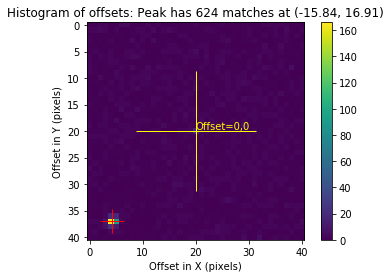

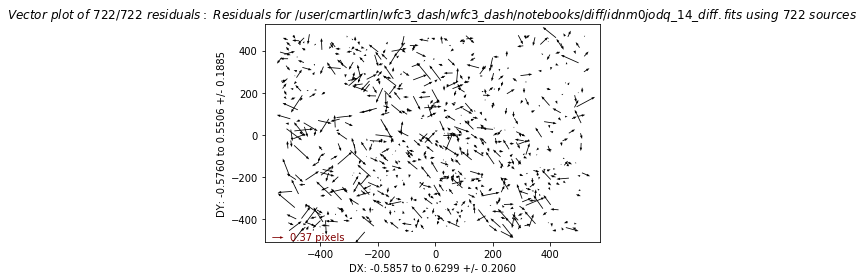

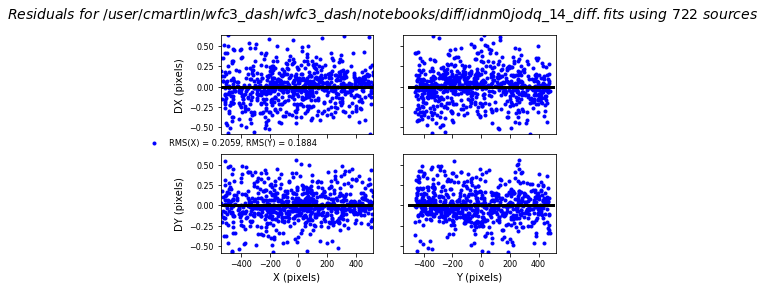

In [71]:
myDash.align(threshold = 20.)

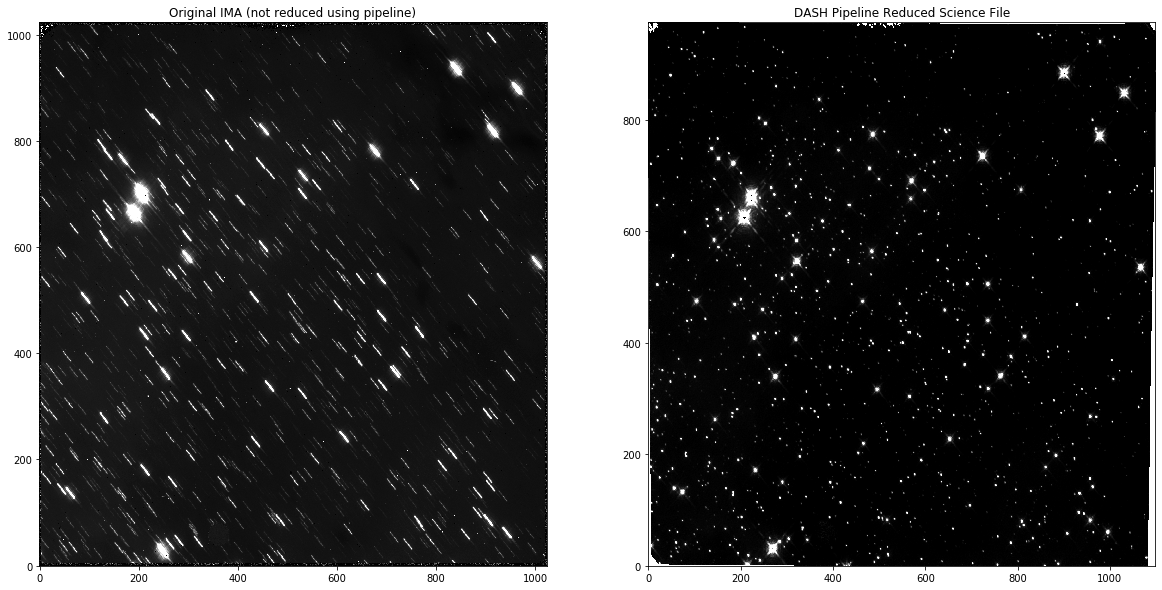

In [72]:
sci_name = myDash.root + '_drz_sci.fits'
og_flt_name = 'mastDownload/HST/' + myDash.root + '/' + myDash.root + '_ima.fits'
sci = fits.getdata(sci_name)
og_flt = fits.getdata(og_flt_name)

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(1,2,2)
ax2 = fig.add_subplot(1,2,1)

ax1.set_title('DASH Pipeline Reduced Science File')
ax2.set_title('Original IMA (not reduced using pipeline)')

ax1.imshow(sci, vmin=0, vmax=40, cmap='Greys_r', origin='lower', aspect="auto")
ax2.imshow(og_flt, vmin=0, vmax=40, cmap='Greys_r', origin='lower', aspect="auto")